See how to use Shor's algorithm to factor 15 here:    <b><a href="https://portal.quantumrings.com/doc/Shors.html">Shor15</a></b>

<i><b>Source code to factorize 15</b></i>

Note: Be sure to use your API token and your account name.

Step 1. Import the required modules and obtain the backend

In [1]:
import QuantumRingsLib
from QuantumRingsLib import QuantumRegister, AncillaRegister, ClassicalRegister, QuantumCircuit
from QuantumRingsLib import QuantumRingsProvider
from QuantumRingsLib import job_monitor
from QuantumRingsLib import JobStatus
from matplotlib import pyplot as plt
import numpy as np
import math

provider = QuantumRingsProvider(
    token='rings-128.YXZRFUMMfK0iaD7TlGMbb9Z2qUh3XrBC',
    name='aryan.malhotra@rutgers.edu'
)
backend = provider.get_backend("scarlet_quantum_rings")
shots = 1024

provider.active_account()

{'name': 'aryan.malhotra@rutgers.edu',
 'token': 'rings-128.YXZRFUMMfK0iaD7TlGMbb9Z2qUh3XrBC',
 'max_qubits': '128'}

Step 2. Define the core methods

In [2]:
def iqft_cct(qc, b, n):
    """
    The inverse QFT circuit

    Args:

        qc (QuantumCircuit):
                The quantum circuit

        b (QuantumRegister):
                The target register

        n (int):
                The number of qubits in the registers to use

    Returns:
        None

    """

    for i in range (n):
        for j in range (1, i+1):
            # for inverse transform, we have to use negative angles
            qc.cu1(  -math.pi / 2** ( i -j + 1 ), b[j - 1], b[i])
        # the H transform should be done after the rotations
        qc.h(b[i])
    qc.barrier()
    return

def plot_histogram (counts, title=""):
    """
    Plots the histogram of the counts

    Args:

        counts (dict):
            The dictionary containing the counts of states

        titles (str):
            A title for the graph.

    Returns:
        None

    """
    fig, ax = plt.subplots(figsize =(10, 7))
    plt.xlabel("States")
    plt.ylabel("Counts")
    mylist = [key for key, val in counts.items() for _ in range(val)]

    unique, inverse = np.unique(mylist, return_inverse=True)
    bin_counts = np.bincount(inverse)

    plt.bar(unique, bin_counts)

    maxFreq = max(counts.values())
    plt.ylim(ymax=np.ceil(maxFreq / 10) * 10 if maxFreq % 10 else maxFreq + 10)
    # Show plot
    plt.title(title)
    plt.show()
    return

Step 3. Perform the algorithm

In [3]:
# Shor’s algorithm to factorize 15 using 7^x mod 15.
numberofqubits = 7
shots = 1024

q = QuantumRegister(numberofqubits , 'q')
c = ClassicalRegister(4 , 'c')
qc = QuantumCircuit(q, c)

# Initialize source and target registers
qc.h(0)
qc.h(1)
qc.h(2)
qc.x(6)
qc.barrier()

# Modular exponentiation 7^x mod 15
qc.cx(q[2],q[4] )
qc.cx(q[2],q[5] )
qc.cx(q[6],q[4] )
qc.ccx(q[1],q[5],q[3] )
qc.cx(q[3],q[5] )
qc.ccx(q[1],q[4],q[6] )
qc.cx(q[6],q[4] ) #
qc.barrier()

# IQFT. Refer to implementation from earlier examples
iqft_cct (qc, q, 3)

# Measure
qc.measure(q[0], c[0])
qc.measure(q[1], c[1])
qc.measure(q[2], c[2])

# Draw the circuit
qc.draw('mpl')

       ┌───┐ ╎                                     ╎ ┌───┐               »
q[0]: ■┤ H ├─╎─────────────────────────────────────╎─┤ H ├───────■───────»
       ├───┤ ╎                                     ╎ └───┘┌──────┴──────┐»
q[1]: ■┤ H ├─╎──────────────────■─────────■────────╎──────┤ U1(-pi/2)   ├»
       ├───┤ ╎                  │         │        ╎      └─────────────┘»
q[2]: ■┤ H ├─╎───■────■─────────│─────────│────────╎─────────────────────»
       └───┘ ╎   │    │       ┌─┴─┐       │        ╎                     »
q[3]: ■──────╎───│────│───────┤ X ├──■────│────────╎─────────────────────»
             ╎ ┌─┴─┐  │  ┌───┐└─┬─┘  │    │  ┌───┐ ╎                     »
q[4]: ■──────╎─┤ X ├──│──┤ X ├──│────│────■──┤ X ├─╎─────────────────────»
             ╎ └───┘┌─┴─┐└─┬─┘  │  ┌─┴─┐  │  └─┬─┘ ╎                     »
q[5]: ■──────╎──────┤ X ├──│────■──┤ X ├──│────│───╎─────────────────────»
       ┌───┐ ╎      └───┘  │       └───┘┌─┴─┐  │   ╎                     »
q[6]: ■┤ X ├─╎───────────

The circuit to factor 15 shown above.

Job Running
Job Done.
Ending Job Monitor


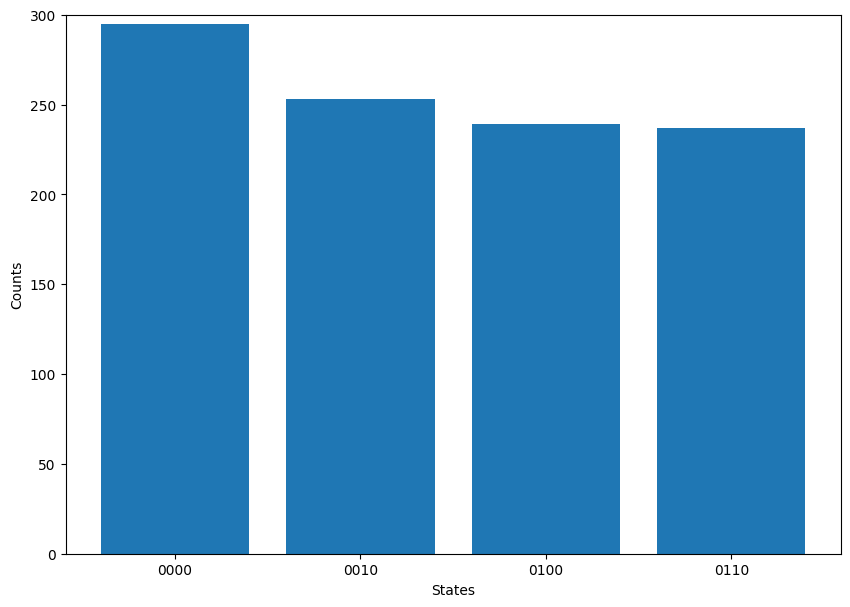

Counts: {'0000': 295, '0010': 253, '0100': 239, '0110': 237}


NameError: name 'Fraction' is not defined

In [4]:
# Execute the circuit
job = backend.run(qc, shots=shots)
job_monitor(job)
result = job.result()
counts = result.get_counts()

# visualize
plot_histogram(counts)

# Print the counts
print("Counts:", counts)

# Calculate the factors
phases = [int(output, 2)/8 for output in counts]
frac = [Fraction(phase).limit_denominator(15) for phase in phases]
r = frac[0].denominator
if r % 2 != 0:
    print("r is odd, try again.")
else:
    guess1 = gcd(7**(r//2)-1, 15)
    guess2 = gcd(7**(r//2)+1, 15)
    print(f"Factors of 15: {guess1} and {guess2}")

#clean up
del q, c, qc
del result
del job

A plot of the execution results is shown above. Compare this with the calculated values.

Footnotes

[1] This section is based on [10], [14], and [16].

[2] https://research.ibm.com/blog/factor-15-shors-algorithm

[3] https://en.wikipedia.org/wiki/Integer_factorization_records#Records_for_efforts_by_quantum_computers